# Capstone Project- The Battle of the Neighborhoods

## Applied Data Science Capstone by IBM/Coursera

### Introduction

*This project is part of the IBM Applied Data Science Capstone Project offered on Coursera.* 

According to Wordometers the United States of America currently has a total population of 330.8 million people . Although cities comprise of just 3.5% of the total land area in the country, 62.7% of the population chooses to live in these metropolitan centers . These cities are most often not just a congregation of people, but culture and services. 

I am currently a graduate student studying in a small college town; however, I am graduating soon and I would like to know which major cities could offer me the best services. Like me, there are many people who are looking to find cities to live in that could offer the services they need. Therefore, this project would be suitable for people who are looking to move to a new city in the United States.

This project will ask people to rate their preferences on what services they prefer and recommend cities that would be the most suitable for them. To achieve this, cities will be clustered on how similar they are based on the services they offer as listed in the Foursquare API, and the entered data will be used to identify the cluster of choice that will be displayed. 


### Data 

Based on the problem described above, the following are the factors that will influence the results of the search:
* The type of services that are offered in each city such as coffee shops, restaurants, parks and theaters
* The number of such services within each city which will provide an indication of what are the most popular services in each city

The data I will be using for this project is listed below:
1.	Foursquare API: This API will be used to identify services, restaurants and shops available in each city and how many of each service is present in each city which will give an idea of its popularity. 
2.	U.S. Largest Cities (Source: [Open data for largest cities in the US](https://public.opendatasoft.com/explore/dataset/1000-largest-us-cities-by-population-with-geographic-coordinates/table/?sort=-rank)): This dataset will holds data on the major cities in the U.S. and the location columns will be used for mapping the cities on the map. The cities listed in this database will be the candidates examined for this project. 


### Initial analysis of the cities listed in the database

We will first perform an exploratory analysis to collect services offered by each city from the Foursquare API and cluster similar cities together.

#### Preprocessing and Visualization of the Dataset

In [138]:
# Importing packages
print('Importing libraries...')
import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
print('Libraries imported! :D')

Importing libraries...
Libraries imported! :D


In [139]:
#Importing cities dataset
!wget -q -O 'cities.csv' https://public.opendatasoft.com/explore/dataset/1000-largest-us-cities-by-population-with-geographic-coordinates/download/?format=csv&timezone=Asia/Shanghai&lang=en&use_labels_for_header=true&csv_separator=%3B
print('Data downloaded!')

Data downloaded!


In [140]:
with open('cities.csv') as cities_data:
    cities= pd.read_csv(cities_data, sep=';')
cities.head(5)

,City,Rank,State,Growth From 2000 to 2013,Population,Coordinates
0,Marysville,552,Washington,115.7,63269,"48.0517637,-122.1770818"
1,Perris,466,California,98.7,72326,"33.7825194,-117.2286478"
2,Cleveland,48,Ohio,-18.1,390113,"41.49932,-81.6943605"
3,Worcester,129,Massachusetts,5.8,182544,"42.2625932,-71.8022934"
4,Columbia,192,South Carolina,11.7,133358,"34.0007104,-81.0348144"


As seen above, the dataset contains information about the city name, rank in terms of population, state, it's population growth and it's location in coordinates. For our analysis, we do not need the information about its population as we understand that all cities in this database are large, so we will remove this information in the following few cells. More importantly, we will split the coordinates column into two separate columns- latitude and longitude to make our analysis easier. 

In [141]:
#Splitting Coordinates column
lat = []
lon = []

# For each row in a varible,
for row in cities['Coordinates']:
    # Try to,
    try:
        # Split the row by comma and append
        # everything before the comma to lat
        lat.append(row.split(',')[0])
        # Split the row by comma and append
        # everything after the comma to lon
        lon.append(row.split(',')[1])
    # But if you get an error
    except:
        # append a missing value to lat
        lat.append(np.NaN)
        # append a missing value to lon
        lon.append(np.NaN)

# Create two new columns from lat and lon
cities['latitude'] = lat
cities['longitude'] = lon

cities.head(5)

,City,Rank,State,Growth From 2000 to 2013,Population,Coordinates,latitude,longitude
0,Marysville,552,Washington,115.7,63269,"48.0517637,-122.1770818",48.0517637,-122.1770818
1,Perris,466,California,98.7,72326,"33.7825194,-117.2286478",33.7825194,-117.2286478
2,Cleveland,48,Ohio,-18.1,390113,"41.49932,-81.6943605",41.49932,-81.6943605
3,Worcester,129,Massachusetts,5.8,182544,"42.2625932,-71.8022934",42.2625932,-71.8022934
4,Columbia,192,South Carolina,11.7,133358,"34.0007104,-81.0348144",34.0007104,-81.0348144


In [142]:
#Selecting relevent columns
cities.drop(['Rank', 'Growth From 2000 to 2013', 'Coordinates'], axis= 1, inplace= True)
cities

,City,State,Population,latitude,longitude
0,Marysville,Washington,63269,48.0517637,-122.1770818
1,Perris,California,72326,33.7825194,-117.2286478
2,Cleveland,Ohio,390113,41.49932,-81.6943605
3,Worcester,Massachusetts,182544,42.2625932,-71.8022934
4,Columbia,South Carolina,133358,34.0007104,-81.0348144
...,...,...,...,...,...
995,Santa Barbara,California,90412,34.4208305,-119.6981901
996,Addison,Illinois,37385,41.931696,-87.9889556
997,Rio Rancho,New Mexico,91956,35.2327544,-106.6630437
998,Normal,Illinois,54664,40.5142026,-88.9906312


Next we will check if any of the cities have NA values or if any of the cities are duplicated within the dataframe. If they are, these values will be removed.

In [143]:
#Checking data cleaning- Removing NAs and Duplicates
display(cities.isnull().any())
print('Are any rows duplicated? ' + str(cities.duplicated().any()))

City          False
State         False
Population    False
latitude      False
longitude     False
dtype: bool

Are any rows duplicated? False


Since there are no NA values and none of the city rows are duplicated, we will move on to visualize the distribution of the cities we are analyzing to understand the distribution of large cities in the US. 

In [230]:
#Checking Central location for United States
address = 'United States of America'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of U.S. are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of U.S. are 39.7837304, -100.4458825.


In [231]:
#Creating map showing all cities in consideration
map_us = folium.Map(location=[latitude, longitude], zoom_start=3)

# add markers to map
for lat, lng, city, state in zip(cities['latitude'], cities['longitude'], cities['City'], cities['State']):
    label = '{}, {}'.format(city, state)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_us)  
    
map_us

#### Using the Foursquare API to get information about the services in each city

In [162]:
#Defining Foursquare Credentials
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: S5CN3L51JZBRUYZVXCMZQOSAMNPOFYXY30PH32JLV0MK5SXT
CLIENT_SECRET:ENVGYBCT5JOAPJH2DD4LQD0ZIOZQYP3TPTUIYSBPYA4OFAU0


In [163]:
#Defining function that will get all the services 
def getNearbyVenues(names, latitudes, longitudes, radius=25000, LIMIT=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except KeyError:
            results= [np.nan, np.nan, np.nan, np.nan]
        
        # return only relevant information for each nearby venue
        try:
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except TypeError: 
            venues_list.append([(
            np.nan, np.nan, np.nan,np.nan,np.nan,np.nan,np.nan,)])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [164]:
us_venues = getNearbyVenues(names=cities['City'],
                                   latitudes=cities['latitude'],
                                   longitudes=cities['longitude'])

Marysville
Perris
Cleveland
Worcester
Columbia
Waterbury
Eagan
Southfield
Lafayette
Boise City
Elkhart
Buena Park
Marietta
Parker
West Palm Beach
Salem
Aurora
Leesburg
Doral
Westminster
Lubbock
Overland Park
Jackson
Gastonia
Daytona Beach
Kansas City
Noblesville
Southaven
Chino
Gaithersburg
Fountain Valley
Frederick
Greenville
DeKalb
West Allis
Thornton
West Des Moines
Fall River
Tulare
Chula Vista
Coral Springs
Concord
Smyrna
Apopka
Grand Forks
Lancaster
Naperville
Hollywood
Rogers
New Orleans
Lakewood
Oak Lawn
Caldwell
Portland
Concord
Burien
St. Charles
Waukesha
Flagstaff
Puyallup
Schenectady
Denver
Springfield
Campbell
Moreno Valley
Kettering
Lincoln Park
Lake Havasu City
North Little Rock
Reno
Littleton
Prescott
Dublin
Texarkana
Portland
Brooklyn Park
West Haven
El Centro
The Colony
Flint
Pittsburg
Buckeye
Brea
Indio
Scottsdale
Columbus
Lancaster
Lincoln
Trenton
Boston
Glendora
Rochester
Florissant
Annapolis
Chapel Hill
Lawrence
Calexico
Calumet City
Missoula
Clovis
Pearland
Gilbe

Mankato
New York
Simi Valley
West Covina
Castle Rock
Valdosta
Fort Worth
Carson
Evansville
Santa Maria
Brentwood
La Mesa
Westminster
Reading
Turlock
Greeley
Tyler
Winter Garden
Waco
Martinez
Thousand Oaks
Azusa
Bridgeport
St. Louis Park
Chesterfield
Greenacres
Pasco
Torrance
Madison
Janesville
Waukegan
Bowling Green
Arlington
Lewisville
Farmington
Oakley
Palo Alto
Springfield
New Bedford
Redmond
Brentwood
Davis
La Mirada
Smyrna
Altoona
Dothan
East Orange
Tinley Park
Biloxi
Urbana
Garden Grove
Lynwood
Northglenn
Canton
Brookhaven
Baton Rouge
Bristol
Independence
Lansing
Orland Park
Vineland
Green Bay
Evanston
Ocoee
Los Angeles
Federal Way
West Jordan
Yucaipa
Pittsburgh
Downey
Cicero
South Gate
Panama City
Joplin
League City
Salt Lake City
Fort Pierce
Phoenix
Corvallis
Cedar Hill
Chicopee
Ocala
Roswell
Park Ridge
Concord
Olympia
Huntington Beach
Corpus Christi
Haverhill
Hanover Park
Cambridge
Glendale
Stanton
Summerville
Davenport
Boca Raton
New Britain
Roseville
Cleveland Heights
Gresha

In [165]:
#Checking DataFrame
print(us_venues.shape)
us_venues.head()

(93029, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marysville,48.0517637,-122.1770818,MOD Pizza,48.051566,-122.177439,Pizza Place
1,Marysville,48.0517637,-122.1770818,Kung Fu Northwest / Kung Fu 4 Kids - Martial Arts,48.055875,-122.180060,Martial Arts Dojo
2,Marysville,48.0517637,-122.1770818,Jennings Memorial Park,48.058690,-122.160932,Park
3,Marysville,48.0517637,-122.1770818,Cristiano's Pizza Etc,48.061627,-122.175588,Pizza Place
4,Marysville,48.0517637,-122.1770818,Haggen,48.076943,-122.180508,Grocery Store


As seen above, the Foursquare API was able to retrive 93029 services for each of the cities. For this study we have limited the number of services to be within a range of 25 Km from the coordinates of the city center and we have limited the number of services to 2000 to get a general understanding of the types of services that are popular within each city. 
Since this code calls for the services of around 1000 cities, the foursquare API might not be able to make multiple runs per day. I have created a csv file of the services in each city directly generated from the code cell above. The following cell can be run in case the foursquare API returns null values for the dataframe above. 

In [177]:
#In case Foursquare is not working
#us_venues= pd.read_csv('Foursquare_db.csv', header=0)

The following cells will process this dataframe to remove any NA values and return information about the number of services and unique categories that are present in the dataframe

In [166]:
#removing na values from dataframe
us_venues.dropna(axis=0, inplace=True)
print(us_venues.shape)
us_venues.head()

(92979, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marysville,48.0517637,-122.1770818,MOD Pizza,48.051566,-122.177439,Pizza Place
1,Marysville,48.0517637,-122.1770818,Kung Fu Northwest / Kung Fu 4 Kids - Martial Arts,48.055875,-122.180060,Martial Arts Dojo
2,Marysville,48.0517637,-122.1770818,Jennings Memorial Park,48.058690,-122.160932,Park
3,Marysville,48.0517637,-122.1770818,Cristiano's Pizza Etc,48.061627,-122.175588,Pizza Place
4,Marysville,48.0517637,-122.1770818,Haggen,48.076943,-122.180508,Grocery Store


In [167]:
#Looking at counts per city
us_venues.groupby('City').count().head()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Abilene,70,70,70,70,70,70
Akron,100,100,100,100,100,100
Alameda,100,100,100,100,100,100
Albany,261,261,261,261,261,261
Albuquerque,100,100,100,100,100,100


In [168]:
#How many unique categories
print('There are {} uniques categories.'.format(len(us_venues['Venue Category'].unique())))

There are 528 uniques categories.


We will then encode each of the venues depending what category they fall under to understand what are the most popular venues based on the frequency of it.

In [169]:
# one hot encoding
us_onehot = pd.get_dummies(us_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
us_onehot['City'] = us_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [us_onehot.columns[-1]] + list(us_onehot.columns[:-1])
us_onehot = us_onehot[fixed_columns]

us_onehot.head()

,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
#Fixing Columns
us_onehot=us_onehot.set_index('City')
us_onehot

,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
City,,,,,,,,,,,,,,,,,,,,,
Marysville,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Marysville,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Marysville,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Marysville,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Marysville,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Grapevine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Grapevine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Grapevine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [171]:
#Grouped by city
us_grouped = us_onehot.groupby('City').mean().reset_index()
us_grouped

,City,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Abilene,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.014286,0.000000,0.00,0.028571,0.0,0.00,0.014286
1,Akron,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.010000,0.000000,0.01,0.020000,0.0,0.00,0.010000
2,Alameda,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.020000,0.00,0.000000,0.0,0.02,0.000000
3,Albany,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.007663,0.011494,0.00,0.003831,0.0,0.00,0.003831
4,Albuquerque,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.010000,0.00,0.000000,0.0,0.00,0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,York,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.000000
879,Youngstown,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.020000,0.000000,0.00,0.010000,0.0,0.00,0.000000
880,Yuba City,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.00,0.010000,0.0,0.00,0.000000
881,Yucaipa,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.01,0.000000


In [172]:
#Function for most popular venue types per city
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [173]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = us_grouped['City']

for ind in np.arange(us_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(us_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abilene,Coffee Shop,American Restaurant,Fast Food Restaurant,Mexican Restaurant,Deli / Bodega,Restaurant,Sandwich Place,Burger Joint,Tex-Mex Restaurant,Steakhouse
1,Akron,Ice Cream Shop,Mexican Restaurant,Burger Joint,Park,Grocery Store,Trail,American Restaurant,Brewery,Sandwich Place,Coffee Shop
2,Alameda,Park,Brewery,Bakery,Trail,Coffee Shop,Movie Theater,Scenic Lookout,Art Museum,Plaza,Café
3,Albany,Coffee Shop,Mexican Restaurant,Grocery Store,Pizza Place,Park,American Restaurant,Ice Cream Shop,Burger Joint,Pub,Café
4,Albuquerque,Brewery,Mexican Restaurant,American Restaurant,Coffee Shop,Pizza Place,Grocery Store,BBQ Joint,Burger Joint,Café,Food Service


The above cell shows the most important venues for each city that is avaliable on the database.

#### Clustering the cities based on the similarity of their services

For this project we will cluster the cities based on the similarity of the frequency of services they offer. 

In [174]:
#K means clustering to visualize
# set number of clusters
kclusters = 10

us_grouped_clustering = us_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(us_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 8, 0, 4, 4, 4, 4, 6, 8, 3], dtype=int32)

In [175]:
# add clustering labels
city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

city_merged = cities

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
city_merged = city_merged.join(city_venues_sorted.set_index('City'), on='City')

city_merged.dropna(axis=0, inplace=True)
city_merged['Cluster Labels']= city_merged['Cluster Labels'].astype(int)

city_merged.head() # check the last columns!

,City,State,Population,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marysville,Washington,63269,48.0517637,-122.1770818,4,Coffee Shop,Brewery,Park,Burger Joint,Bakery,Grocery Store,Pizza Place,Seafood Restaurant,Warehouse Store,American Restaurant
1,Perris,California,72326,33.7825194,-117.2286478,2,Fast Food Restaurant,Coffee Shop,Mexican Restaurant,Grocery Store,Park,Sandwich Place,Hardware Store,Bakery,Breakfast Spot,Pharmacy
2,Cleveland,Ohio,390113,41.49932,-81.6943605,3,Park,Grocery Store,Coffee Shop,Ice Cream Shop,Sandwich Place,Mexican Restaurant,American Restaurant,Brewery,Fast Food Restaurant,Pizza Place
3,Worcester,Massachusetts,182544,42.2625932,-71.8022934,3,American Restaurant,Coffee Shop,Donut Shop,Pizza Place,Golf Course,Bakery,Bar,Fast Food Restaurant,Grocery Store,Seafood Restaurant
4,Columbia,South Carolina,133358,34.0007104,-81.0348144,3,Coffee Shop,Pizza Place,Grocery Store,American Restaurant,Burger Joint,Brewery,Ice Cream Shop,Fast Food Restaurant,Mexican Restaurant,Trail


Average distance to centroid: 0.1442336900246491


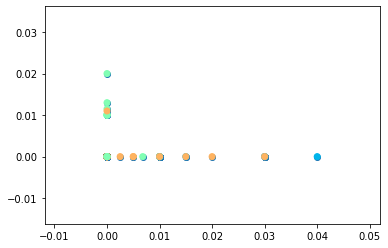

In [281]:
#Checking for degree of error
X = np.array(us_grouped_clustering)
plt.scatter(X[:,0],X[:,1], label = 'True Position')

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

## print(kmeans.cluster_centers_)

plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='rainbow')
## plt.show()

distances = kmeans.fit_transform(X)
variance = 0
i = 0
for label in kmeans.labels_:
    variance = variance + distances[i][label]
    i = i + 1

mean_distance = np.mean(distances)
print('Average distance to centroid: ' + str(mean_distance))

In [176]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['latitude'], city_merged['longitude'], city_merged['City'], city_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The map above shows the cities and the clusters they fall within based on the similarity of the services they offer.

#### User defined City Search

The following cells will generate an output of the cities the user might like based on the preferences they set on the type of service they feel are most important to them

In [282]:
#Creating a separate user table
user_reftable=us_grouped

user_reftable.head()

,City,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Abilene,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.014286,0.000000,0.00,0.028571,0.0,0.00,0.014286
1,Akron,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.010000,0.000000,0.01,0.020000,0.0,0.00,0.010000
2,Alameda,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.020000,0.00,0.000000,0.0,0.02,0.000000
3,Albany,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.007663,0.011494,0.00,0.003831,0.0,0.00,0.003831
4,Albuquerque,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.010000,0.00,0.000000,0.0,0.00,0.010000


**Running the following cell will ask for a user input that will be used to process which cities the user might like to live in. Answer the raw input questions and enter the name of the services exactly as they appear on the table that will appear.**

In [283]:
#defining user needed data

c_name= input("What is your name? " )
imp= []
print('Please choose services from the following list: ')
data= list(user_reftable.columns)
chunks = [data[x:x+10] for x in range(0, len(data), 10)]
cat_table= pd.DataFrame(chunks)
display(cat_table)
for i in range(10):
    if i==0:
        p= input('What is the most important service? ')
    elif i==1:
        p= input('What is the ' + str(i+1) + 'nd most important service?')
    elif i==2:
        p= input('What is the ' + str(i+1) + 'rd most important service?')
    else:
        p= input('What is the ' + str(i+1) + 'th most important service?')
    imp.append(p)

print('Thank you for your input!')

What is your name? Avnika
Please choose services from the following list: 


,0,1,2,3,4,5,6,7,8,9
0,City,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge
1,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Apres Ski Bar,Aquarium,Arcade,Arepa Restaurant
2,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership
3,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium
4,Basketball Court,Basketball Stadium,Bath House,Bathing Area,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar
5,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore
6,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge
7,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Business Service,Butcher,Café,Cajun / Creole Restaurant
8,Cambodian Restaurant,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant
9,Carpet Store,Casino,Castle,Cave,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria


What is the most important service? Supermarket
What is the 2nd most important service?Grocery Store
What is the 3rd most important service?University
What is the 4th most important service?Train Station
What is the 5th most important service?Shopping Mall
What is the 6th most important service?Pub
What is the 7th most important service?Gym
What is the 8th most important service?High School
What is the 9th most important service?Waterfront
What is the 10th most important service?Park
Thank you for your input!


The following few cells will process the information entered by the user and assign values of frequency to each of the categories that are listed by the user. Since the maximum value for frequency listed in the table is 0.23, values assigned will go in decreasing order from 0.23-0.01 to take the users preference into account. These values will then be used to cluster similar cities together and generate an output. 

In [284]:
#Processing user table and adding additional row for user data
user_reftable= user_reftable.append({'City': c_name+"'s City"}, ignore_index=True)
user_row=user_reftable[user_reftable['City']==c_name+"'s City"].index[0]
user_reftable.set_index('City', inplace=True)
user_reftable

,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
City,,,,,,,,,,,,,,,,,,,,,
Abilene,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.014286,0.000000,0.00,0.028571,0.0,0.00,0.014286
Akron,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.010000,0.000000,0.01,0.020000,0.0,0.00,0.010000
Alameda,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.020000,0.00,0.000000,0.0,0.02,0.000000
Albany,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.007663,0.011494,0.00,0.003831,0.0,0.00,0.003831
Albuquerque,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.010000,0.00,0.000000,0.0,0.00,0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Youngstown,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.020000,0.000000,0.00,0.010000,0.0,0.00,0.000000
Yuba City,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.00,0.010000,0.0,0.00,0.000000
Yucaipa,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.01,0.000000


In [285]:
#Setting User Preferences
user_reftable.loc[c_name+"'s City", imp[0]]= 0.23
user_reftable.loc[c_name+"'s City", imp[1]]= 0.20
user_reftable.loc[c_name+"'s City", imp[2]]=0.18
user_reftable.loc[c_name+"'s City", imp[3]]=0.15
user_reftable.loc[c_name+"'s City", imp[4]]=0.13
user_reftable.loc[c_name+"'s City", imp[5]]=0.10
user_reftable.loc[c_name+"'s City", imp[6]]=0.08
user_reftable.loc[c_name+"'s City", imp[7]]=0.05
user_reftable.loc[c_name+"'s City", imp[8]]=0.03
user_reftable.loc[c_name+"'s City", imp[9]]=0.01

user_reftable.replace(np.nan, 0.0, inplace= True)
user_reftable.tail()

,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
City,,,,,,,,,,,,,,,,,,,,,
Youngstown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.02,0.0,0.0,0.01,0.0,0.00,0.0
Yuba City,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.00,0.0,0.0,0.01,0.0,0.00,0.0
Yucaipa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.01,0.0
Yuma,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.00,0.0,0.0,0.01,0.0,0.00,0.0
Avnika's City,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.03,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0


In [286]:
user_reftable.reset_index(inplace=True)
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
user_venues_sorted = pd.DataFrame(columns=columns)
user_venues_sorted['City'] = user_reftable['City']

for ind in np.arange(user_reftable.shape[0]):
    user_venues_sorted.iloc[ind, 1:] = return_most_common_venues(user_reftable.iloc[ind, :], num_top_venues)

user_venues_sorted.tail()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
879,Youngstown,Italian Restaurant,Coffee Shop,Sandwich Place,Ice Cream Shop,Gas Station,Donut Shop,Bar,Pizza Place,Park,American Restaurant
880,Yuba City,Mexican Restaurant,Sandwich Place,Coffee Shop,Fast Food Restaurant,Italian Restaurant,Pharmacy,Convenience Store,Steakhouse,Discount Store,Pizza Place
881,Yucaipa,Coffee Shop,Mexican Restaurant,Fast Food Restaurant,Grocery Store,Café,Breakfast Spot,Farm,American Restaurant,Thai Restaurant,Pharmacy
882,Yuma,Mexican Restaurant,Fast Food Restaurant,American Restaurant,Grocery Store,Burger Joint,Coffee Shop,Pharmacy,Park,Steakhouse,Hotel
883,Avnika's City,Supermarket,Grocery Store,University,Train Station,Shopping Mall,Pub,Gym,High School,Waterfront,Park


In [287]:
#K means clustering to visualize
# set number of clusters
kclusters = 10

user_grouped_clustering = user_reftable.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(user_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 9, 4, 0, 0, 0, 0, 5, 6, 9], dtype=int32)

In [288]:
# add clustering labels
user_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

user_merged = cities

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
user_merged = user_merged.join(user_venues_sorted.set_index('City'), on='City')

user_merged.dropna(axis=0, inplace=True)
user_merged['Cluster Labels']= user_merged['Cluster Labels'].astype(int)

user_merged.tail() # check the last columns!

,City,State,Population,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
986,Flower Mound,Texas,68609,33.0145673,-97.0969552,0,Mexican Restaurant,Coffee Shop,Pizza Place,BBQ Joint,Fast Food Restaurant,Salon / Barbershop,Brewery,Supermarket,Park,Ice Cream Shop
987,Grapevine,Texas,50195,32.9342919,-97.0780654,9,Mexican Restaurant,Pizza Place,American Restaurant,Coffee Shop,Park,Ice Cream Shop,BBQ Joint,Grocery Store,New American Restaurant,Sandwich Place
990,Fairfield,Ohio,42635,39.3454673,-84.5603187,6,Fast Food Restaurant,Park,Grocery Store,Coffee Shop,Clothing Store,Burger Joint,Pizza Place,Bakery,Asian Restaurant,Steakhouse
991,Mansfield,Texas,60872,32.5631924,-97.1416768,1,American Restaurant,Pizza Place,Supermarket,Mexican Restaurant,Chinese Restaurant,Coffee Shop,Department Store,Ice Cream Shop,Steakhouse,Italian Restaurant
992,Rochester,New York,210358,43.16103,-77.6109219,6,Grocery Store,Pizza Place,Coffee Shop,Pub,Convenience Store,Ice Cream Shop,Park,American Restaurant,Sandwich Place,Bar


In [289]:
user_cluster=user_venues_sorted[user_venues_sorted['City']==c_name+"'s City"]['Cluster Labels'].values[0]
print('Your suggested cities are in cluster : ' +str(user_cluster))

Your suggested cities are in cluster : 6


As seen in the cell above, the cluster of cities that the user might enjoy has a label displayed above.

**THE FOLLOWING TABLE DISPLAYS THE CITIES THE USER MIGHT ENJOY BASED ON THE SERVICES THEY FIND ARE THE MOST IMPORTANT**

In [290]:
user_cities= user_merged[user_merged['Cluster Labels']==user_cluster]
user_cities

,City,State,Population,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Lafayette,Louisiana,124276,30.2240897,-92.0198427,6,Grocery Store,Coffee Shop,Pizza Place,Cajun / Creole Restaurant,Fast Food Restaurant,Burger Joint,Sandwich Place,Pharmacy,Mexican Restaurant,Brewery
13,Parker,Colorado,48608,39.5186002,-104.7613633,6,Grocery Store,Coffee Shop,Pizza Place,Fast Food Restaurant,Brewery,American Restaurant,Gym,Liquor Store,Hardware Store,Golf Course
18,Doral,Florida,50213,25.8195424,-80.3553302,6,American Restaurant,Grocery Store,Coffee Shop,Bakery,Café,Department Store,Mexican Restaurant,Italian Restaurant,Donut Shop,Shopping Mall
21,Overland Park,Kansas,181260,38.9822282,-94.6707917,6,BBQ Joint,Grocery Store,American Restaurant,Ice Cream Shop,Park,Coffee Shop,Pizza Place,Liquor Store,Sandwich Place,Italian Restaurant
26,Noblesville,Indiana,56540,40.0455917,-86.0085955,6,American Restaurant,Ice Cream Shop,Pizza Place,Grocery Store,Park,Breakfast Spot,Coffee Shop,Furniture / Home Store,Fast Food Restaurant,Cajun / Creole Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,Plano,Texas,274409,33.0198431,-96.6988856,6,Grocery Store,Pizza Place,Park,Taco Place,Fast Food Restaurant,BBQ Joint,Wine Shop,Movie Theater,Bakery,Sushi Restaurant
959,Gainesville,Florida,127488,29.6516344,-82.3248262,6,Grocery Store,American Restaurant,Pizza Place,Mexican Restaurant,Brewery,Coffee Shop,Donut Shop,BBQ Joint,Italian Restaurant,Department Store
963,Fayetteville,Arkansas,78960,36.0625795,-94.1574263,6,Grocery Store,Burger Joint,Sandwich Place,Coffee Shop,Fried Chicken Joint,Fast Food Restaurant,Japanese Restaurant,Pizza Place,Bakery,Brewery
990,Fairfield,Ohio,42635,39.3454673,-84.5603187,6,Fast Food Restaurant,Park,Grocery Store,Coffee Shop,Clothing Store,Burger Joint,Pizza Place,Bakery,Asian Restaurant,Steakhouse


**THE FOLLOWING MAP SHOWS THE CITIES ON A MAP OF THE U.S. SO THE USERS CAN VISUALLY EXPLORE THE CITIES THAT THEY MIGHT ENJOY.**

In [292]:
# create map
user_map = folium.Map(location=[latitude, longitude], zoom_start=3)


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(user_cities['latitude'], user_cities['longitude'], user_cities['City'], user_cities['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(user_map)
       
user_map

### Results and Discussion

The results show the different cities that are suitable for users with different interests. The number of clusters chosen for this project was 10, which means it can only recommend that the user's city would be in clusters 0-9. The following list shows what venues seem to be the most popular in each cluster:

* Cluster 0: Fast Food Restaurants, American Restaurants and Mexican Restaurants are the most important venues
* Cluster 1: American Restaurants and Parks seem to be the most important venues
* Cluster 2: Fast Food Restaurants, Theme Parks and Grocery Stores are the most important venues
* Cluster 3: Coffee Shops and Parks seem to be the most important venues
* Cluster 4: Beaches, Seafood Restaurants and Parks seem to be the most popular
* Cluster 5: Coffee Shops, Grocery Stores and Pizza Places seem to be the most popular venues
* Cluster 6: Grocery stores, Hot Dog Joints, Bakeries and Breweries are the most important venues
* Cluster 7: Supermarkets and Coffee Shops seem to be the most important venues
* Cluster 8: Fast Food Restaurants, Grocery stores and Coffee Shops are the most important venues
* Cluster 9: Parks, Bakeries and Pizza Places are the most important venues

While this project is able to classify the cities into 10 main groups, it could be helpful if an estimation can be done on the error that the classification has and this could be taken into account when dividing the cities into the number of clusters. 

### Conclusion

While this project gives the suggested cities users may look into based on their requirements for the most popular services, there are other considerations, such as the size of the city, crime rate and housing prices, that the users should look into before deciding to move. This tool can give a suggestion on the cities as a starting point for users to look into and research about deeper. 

Future work into this project could include an analysis on crime, size and housing cost as part of the analysis and ask the user specifically for their preferences on these statistics. This will give them a well-rounded analysis as it would be a one-stop solution for understanding the cities that are best suited for their needs. Furthermore, a deeper analysis on the best k value would prove to be beneficial to providing the user with a more accurate set of cities. 

This project, therefore, uses a starting point of the largest cities in the U.S., uses the Fourquare API to identify the most important services in each city and clusters similar cities together. The code then asks the user to add the services most important to them in order and finds a cluster of cities that are most suitable for them.
